<a href="https://colab.research.google.com/github/kourmouOmar/min-projet-nlp/blob/master/Covid_19_tweets_analysing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cp -r ../input/tweetcovid19/* ./

# Sentiment analysing of covid-19 tweets

Tweets or commonts helps us to better understand what is going through everyones thinking, how it has impacted the life of so many people and also some positive effects that this pandemic has caused.

As a first step is installing python and all other packages witch we will need in our mini project

In [ ]:
#Import the necessary libraries
import pandas as pd
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import re
import nltk
import string


In [ ]:
df = pd.read_csv('covid19_tweets.CSV')



```
# Ce texte est au format code
```

Looking the top five rows of our dataset for having an overview

In [ ]:
df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1244051646071611394,860252856829587457,2020-03-29T00:00:00Z,IMSS_SanLuis,"Ante cualquier enfermedad respiratoria, no te ...",TweetDeck,NaN,NaN,NaN,False,False,300,0,NaN,NaN,NaN,1008,41,NaN,2017-05-04T22:00:38Z,False,es
1,1244051645039706112,1125933654943895553,2020-03-29T00:00:00Z,intrac_ccs,#ATENCIÓN En el Terminal Nuevo Circo se implem...,TweetDeck,NaN,NaN,NaN,False,False,1030,1,NaN,NaN,NaN,90,316,NaN,2019-05-08T01:21:16Z,False,es
2,1244051645975191557,80943559,2020-03-29T00:00:00Z,rlieving,“People are just storing up. They are staying ...,TweetDeck,NaN,NaN,NaN,False,False,604,0,NaN,NaN,NaN,136,457,NaN,2009-10-08T21:06:08Z,False,en
3,1244051646750928897,817072420947247104,2020-03-29T00:00:00Z,Tu_IMSS_Coah,"Si empezaste a trabajar, necesitas dar de alta...",TweetDeck,NaN,NaN,NaN,False,False,1827,0,NaN,NaN,NaN,1549,170,NaN,2017-01-05T18:17:00Z,False,es
4,1244051647032102914,788863557349670913,2020-03-29T00:00:00Z,Tabasco_IMSS,Una sociedad informada está mejor preparada an...,TweetDeck,NaN,NaN,NaN,False,False,723,0,NaN,NaN,NaN,868,125,NaN,2016-10-19T22:05:03Z,False,es


Columns and also the 'screen_name' column can be dropped 

as they wont be necessary during Visualization

In [ ]:
df.drop(['status_id', 'user_id', 'screen_name'], axis = 1, inplace = True)

Check the amount of missing values present

In [ ]:
num_tweets = len(df)

In [ ]:
df.isnull().sum()/num_tweets * 100

created_at                0.000000
text                      0.000000
source                    0.000000
reply_to_status_id       86.298470
reply_to_user_id         83.633215
reply_to_screen_name     83.633215
is_quote                  0.000000
is_retweet                0.000000
favourites_count          0.000000
retweet_count             0.000000
country_code             94.092177
place_full_name          94.082556
place_type               94.082556
followers_count           0.000000
friends_count             0.000000
account_lang            100.000000
account_created_at        0.000000
verified                  0.000000
lang                      0.000000
dtype: float64

In [ ]:
missing_cols = list(df.columns[(df.isnull().sum()/num_tweets * 100) > 85.0])

df.drop(missing_cols, axis = 1, inplace = True)

Checking how many languages there are by adding a 'Language' column using the given language codes.

In [ ]:
from iso639 import languages

def get_language(x):
    try:
        return languages.get(alpha2=x).name 
    except KeyError:
        return x

In [ ]:
df['language'] = df['lang'].apply(lambda x: get_language(x))

In [ ]:
df['language'].value_counts()[:10]

English       5651
Spanish       2437
und            675
French         359
Portuguese     337
Turkish        158
Italian        126
Japanese       112
in              98
Arabic          81
Name: language, dtype: int64

As we can see that there are a lot of languages, but english language remains the most dominant with 5651 score in our dataset.

In [ ]:
df['language'] = df['language'].str.replace('und','Undefined') # we replace languages that are unknown by the string Undefined

Now we are going to display barplot, that will appear the top ten languages with most Tweets.

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = df['language'].value_counts()[:10].index , y = df['language'].value_counts()[:10]/num_tweets*100)
plt.xlabel('Language', fontsize = 20)
plt.ylabel('Percentage of Tweets', fontsize = 20)
plt.xticks(fontsize = 15)
plt.title('Top Ten Languages with most Tweets', fontsize=20)
plt.show()

We can see that 56% of all tweets are in English which is no surprise followed by Spanish and French at 23% and 4% respectively.

# Classification

Before We can continue with any visualization We have to first Classify the sentiment of each tweet

For now We'll be only focusing on the English tweets

In [ ]:
df_eng = df[df['language'] == 'English']

In [ ]:
df_eng['language'].value_counts()

English    5651
Name: language, dtype: int64

Let's take a look at one of the tweets

In [ ]:
import preprocessor as p 

df_eng['text'][1127]

'#BRUH 😂😁😁😁 im dying cause when I got this pic I was deas looking for shit to eat in the kitchen 😂🤣🤣\r\n\r\n#covid_19 #covid19 #coronavirus #quarantined https://t.co/RPlQOLaVyF'

In any machine learning task, cleaning or preprocessing the data is as important as model building if not more. 
And when it comes to unstructured data like text, this process is even more important.

As we can see, the tweets are not clean. They contain URLs, hashtags, stop words, special characters and some also contain emoticons. We therefore apply several techniques to clean and tokenize them.

In [ ]:
df_eng['text'] = df_eng['text'].str.lower() # Lower Casing

# clean() removes urls, emoticons and hashtags
df_eng['clean_text'] = df_eng['text'].apply(lambda text: p.clean(text)) 
df_eng['clean_text'][1127]

'im dying cause when i got this pic i was deas looking for shit to eat in the kitchen'

### Stop words

Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence.
These stopword lists are already compiled for different languages and we can safely use them. For example, the stopword list for english language from the nltk package can be seen below.



In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_eng['clean_text'] = df_eng['clean_text'].apply(lambda text: remove_stopwords(text))

df_eng['clean_text'][1127]

'im dying cause got pic deas looking shit eat kitchen'

In [ ]:
# Removal of punctions

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df_eng['clean_text'] = df_eng['clean_text'].apply(lambda text: remove_punctuation(text))

### Stemming

Stemming ara all process of reducing inflected (or sometimes derived) words to their word stem, base or root form .

For example, if there are two words in the corpus walks and walking, then stemming will stem the suffix to make them walk. But say in another example, we have two words console and consoling, the stemmer will remove the suffix and make them consol which is not a proper english word.

There are several type of stemming algorithms available and one of the famous one is porter stemmer which is widely used. We can use nltk package for the same.

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df_eng['text_stemming'] = df_eng['clean_text'].apply(lambda text: stem_words(text))
df_eng['text_stemming'][1127]

'im die caus got pic dea look shit eat kitchen'

We can see that, the word "cause" has its e at the end cut off due to the root. It's not planned. What can we do strong hat? We can use lemmatization in such cases.

### Lemmatization

Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language.

As a result, this one is generally slower than stemming process. So depending on the speed requirement, we can choose to use either stemming or lemmatization.

In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df_eng['clean_text'] = df_eng['clean_text'].apply(lambda text: lemmatize_words(text))

df_eng['clean_text'][1127]

'im die cause get pic dea look shit eat kitchen'

### Tokenization

Tokenization is a way of separating a piece of text into smaller units called tokens.

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
df_eng['clean_text'] = df_eng['clean_text'].apply(lambda text: word_tokenize(text))
df_eng['clean_text'][1127]

['im', 'die', 'cause', 'get', 'pic', 'dea', 'look', 'shit', 'eat', 'kitchen']

All the tweets have been cleaned and tokenized. This will make it easier to vectorize the words and help the model to predict the sentiment of each tweet.

In [ ]:
#Saving the dataframe as a pickle file to pick up where we left off in the event of a kernel failure or if we need to continue another day
df_eng.to_pickle('pickle_files/tweets_eng.pkl') #Also reading and writing pickle files are much faster than csv

In [ ]:
df_eng = pd.read_pickle('pickle_files/tweets_eng.pkl')

### Word Embeddings

Before we can start with the classification we have to find a way to represent the words.
Now there two popular ways to do this: <b> Word Vectors</b> and <b>Word Embeddings</b>

<b>Word Vectors</b> are high dimensional sparse (mostly 0s) vectors where each vector represents a word which is simply one hot encoded.
<b>Word Embeddings</b> unlike word vectors represent the words in dense vectors. The words are mapped into a meaningful space where the distance between words is related to their semantic similarity.


We'll be using pretrained <b>GloVe</b> embeddings to represent the words

In [ ]:
docs = df_eng['clean_text']

#tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

#encode the documents
encoded_docs = t.texts_to_sequences(docs)

#pad docs to max length
padded_docs = pad_sequences(encoded_docs, maxlen = 22, padding = 'post') 

As the sentiments for the tweets have not been provided the classifier can be trained on any public data which contains labels.  So we trained our model on a dataset in which the tweets were separated into three sentiments <b> 'Positive', 'Negative' </b> and <b> "Neutral" </b>.

This dataset was trained on a 6 layer <b>LSTM</b> network with pretained <b>GloVe embeddings</b>.

In [ ]:
# Loading the classifier 
classifier = keras.models.load_model('Models/sentiment_classifier4.h5') #Negative: 0, Neutral: 1, Postive: 2

In [ ]:
labels_categorical = classifier.predict(padded_docs) # Predicting the Sentiments of the Covid-19 tweets

In [ ]:
labels_categorical[:10] #Output of each class by the softmax function

array([[9.9503267e-01, 4.5689004e-03, 3.9846174e-04],
       [5.6318748e-01, 3.5422221e-01, 8.2590275e-02],
       [6.5708108e-02, 8.6280119e-01, 7.1490638e-02],
       [1.4433160e-02, 9.3945868e-02, 8.9162093e-01],
       [9.5613909e-01, 3.8959440e-02, 4.9015256e-03],
       [5.1497740e-01, 2.1291922e-01, 2.7210337e-01],
       [7.3797642e-03, 4.2366963e-02, 9.5025331e-01],
       [5.1529145e-01, 3.4277585e-01, 1.4193268e-01],
       [2.9250911e-01, 2.4895254e-01, 4.5853835e-01],
       [9.9633187e-01, 2.8349322e-03, 8.3320227e-04]], dtype=float32)

In [ ]:
np.argmax(labels_categorical[:10], axis = 1) #np.argmax to get labels of the classes Negative: 0, Neutral: 1, Postive: 2

array([0, 0, 1, 2, 0, 0, 2, 0, 2, 0], dtype=int64)

In [ ]:
df_eng['labels'] = np.argmax(labels_categorical, axis = 1)

In [ ]:
df_eng.to_pickle('pickle_files/final_df.pkl') 

In [ ]:
df_eng = pd.read_pickle('pickle_files/final_df.pkl')

In [ ]:
def label_to_sentiment(label):
    if label == 0:
        return 'Negative'
    elif label == 1:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
df_eng['sentiment'] = df_eng['labels'].apply(lambda x: label_to_sentiment(x))

In [ ]:
pd.set_option('max_colwidth', 200)
df_eng[['text','sentiment']].iloc[368:373] #Let's check some random tweets to see if the predicted sentiments make sense

,text,sentiment
726,"@narendramodi at this time when all of us need to help our fellow indians in whatever way we can, pledges to contribute a small amount ₹ 1001 to @narendramodi ji's pm- cares fund. let's all save l...",Negative
729,"abbott launches molecular point-of-care test to detect novel coronavirus in as little as five minutes - mar 27, 2020 #covid_19 #covid_19test ⁦@govwhitmer⁩ https://t.co/ige1dikaeh",Negative
733,"instacart’s gig workers are planning a massive, nationwide strike https://t.co/fljqyku3kc via @vice #coronavirus #instacart #gigworkers",Neutral
736,"@joebiden even his ego is delusional, separate from himself. he’s on a trajectory to being the worstest in presidenting, when it’s all written @ @history @biography @wikipedia , and when you @goog...",Negative
739,"in my eyes, the best solution to deal with #covid_19 is to treat it like we handled wwii. we declare what is effectively a state of total war and every business helps the cause. (1/5)",Negative


We can see that the classifier has managed to classify the sentiments quite well.

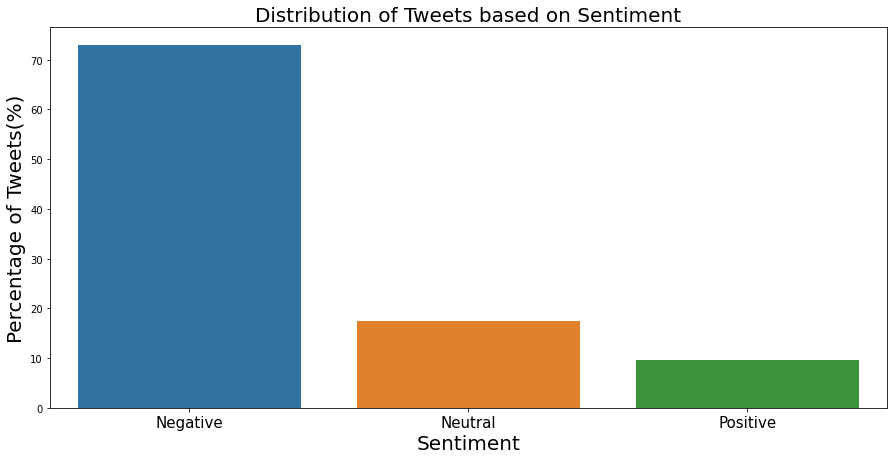

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = df_eng['sentiment'].value_counts().index, y = df_eng['sentiment'].value_counts()/len(df_eng)*100)
plt.xlabel('Sentiment', fontsize = 20)
plt.ylabel('Percentage of Tweets(%)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.title('Distribution of Tweets based on Sentiment', fontsize = 20)
plt.show()

73% of the tweets are Negative whereas only 10% of the tweets are Positive.

In [ ]:
from wordcloud import WordCloud
def plot_wordcloud(data):
    words = []
    for sent in data:
        for word in sent:
            words.append(word) 
    words = pd.Series(words).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(words)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

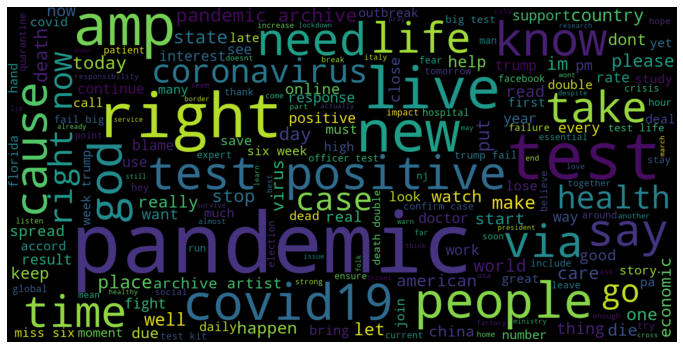

In [ ]:
plot_wordcloud(df_eng['clean_text'][df_eng['sentiment'] == 'Positive'])

There some words which are common in both the positive and negative tweets like Coronavirus et Pandemic because they are the main subject of these tweets and are therefore in most of them.

<b>Positive tweets:</b> These mostly contain words like 'help','protect' et 'responsability' which are related to spreading awareness about how the spread of virus can be slowed down by staying at home and containing the pandemic.

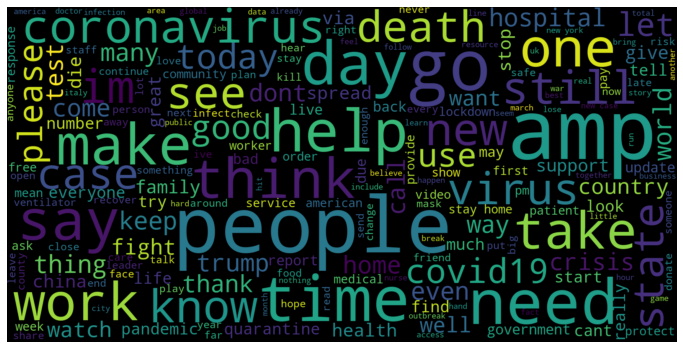

In [ ]:
plot_wordcloud(df_eng['clean_text'][df_eng['sentiment'] == 'Negative'])

<b>Negative tweets:</b> These tweets mostly contain words like 'country', 'work', 'crisis' which are related to how countries are facing heavy losses during this lockdown and how this has caused many employees to be laid off as their companies are not able to make enough profits.

# Hashtags Visualization

Hashtags help to categorize any content. Therefore in a way they give a good idea about the theme and contents of a particular tweet.

In [ ]:
def extract_hashtag(text):
    hashtags=[]
    for i in text:
        ht=re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    return hashtags

In [ ]:
all_hashtags=extract_hashtag(df_eng.text)
def df_hashtag(sentiment_label):
    hashtags=extract_hashtag(df_eng.text[df_eng['sentiment']==sentiment_label])
    ht_fredist=nltk.FreqDist(sum(hashtags,[]))
    df_ht=pd.DataFrame({'Hashtag':list(ht_fredist.keys()),'Count':list(ht_fredist.values())})
    return df_ht

In [ ]:
#Hashtags dataframes
ht_neg_df=df_hashtag('Negative')
ht_neu_df=df_hashtag('Neutral')
ht_pos_df=df_hashtag('Positive')

In [ ]:
ht_neg_df.to_pickle('pickle_files/ht_neg_df.pkl')
ht_neu_df.to_pickle('pickle_files/ht_neu_df.pkl')
ht_pos_df.to_pickle('pickle_files/ht_pos_df.pkl')

In [ ]:
ht_neg_df = pd.read_pickle('pickle_files/ht_neg_df.pkl')
ht_neu_df = pd.read_pickle('pickle_files/ht_neu_df.pkl')
ht_pos_df = pd.read_pickle('pickle_files/ht_pos_df.pkl')

In [ ]:
def plot_hashtag(df,title):
    data=df.nlargest(columns="Count",n=20)
    plt.figure(figsize=(16,5))
    ax=sns.barplot(data=data,x='Hashtag',y='Count')
    plt.suptitle(title, fontsize=20)
    plt.xlabel('Hashtag', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.xticks(rotation=90)
    plt.tick_params(labelsize=15)
    plt.show()

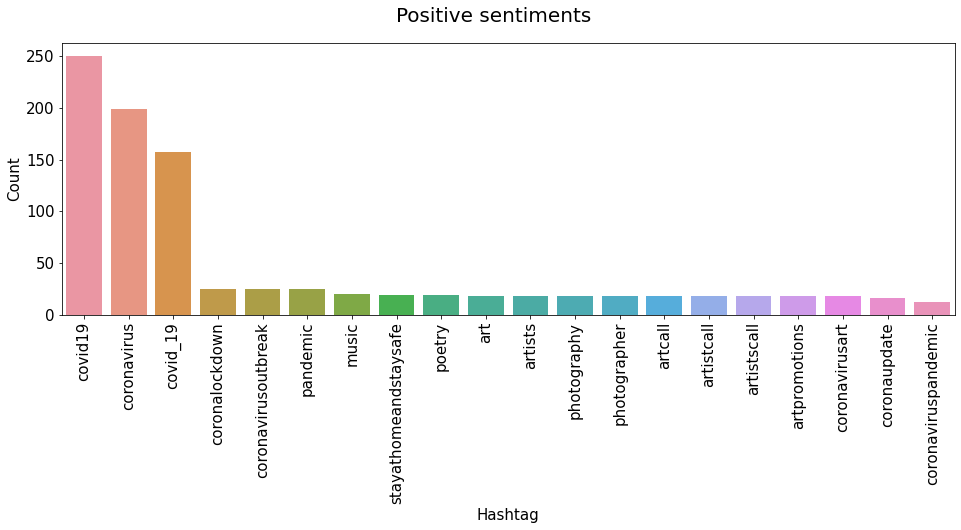

In [ ]:
plot_hashtag(ht_pos_df,'Positive sentiments')

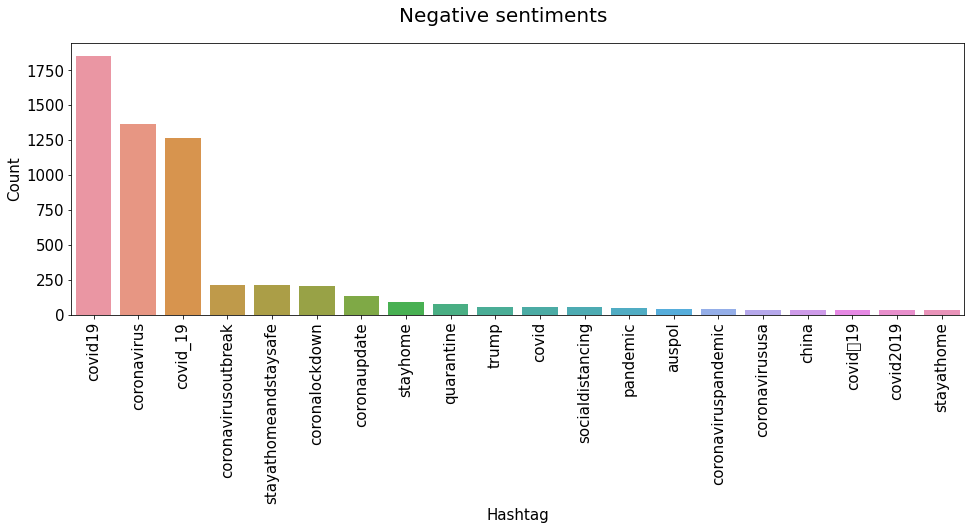

In [ ]:
plot_hashtag(ht_neg_df,'Negative sentiments')

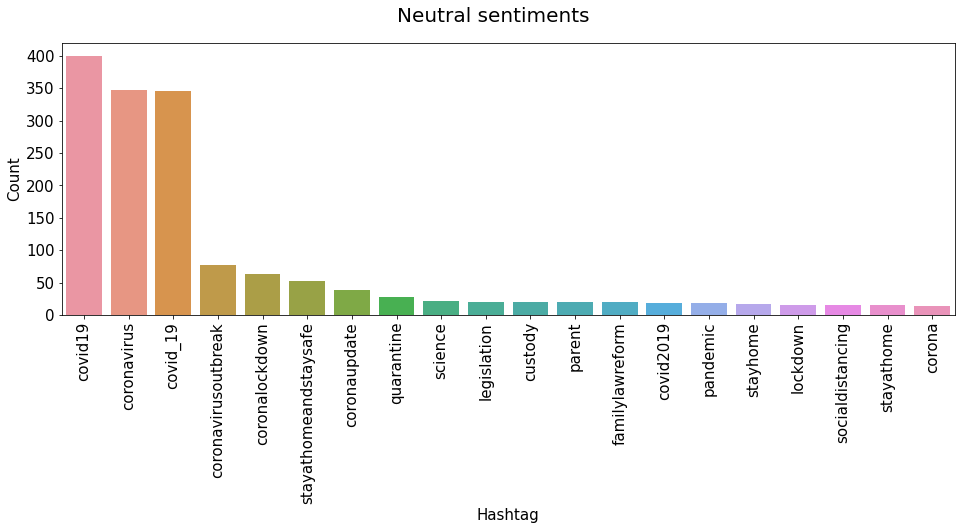

In [ ]:
plot_hashtag(ht_neu_df,'Neutral sentiments')

## Sentiment-wise Likes ratio

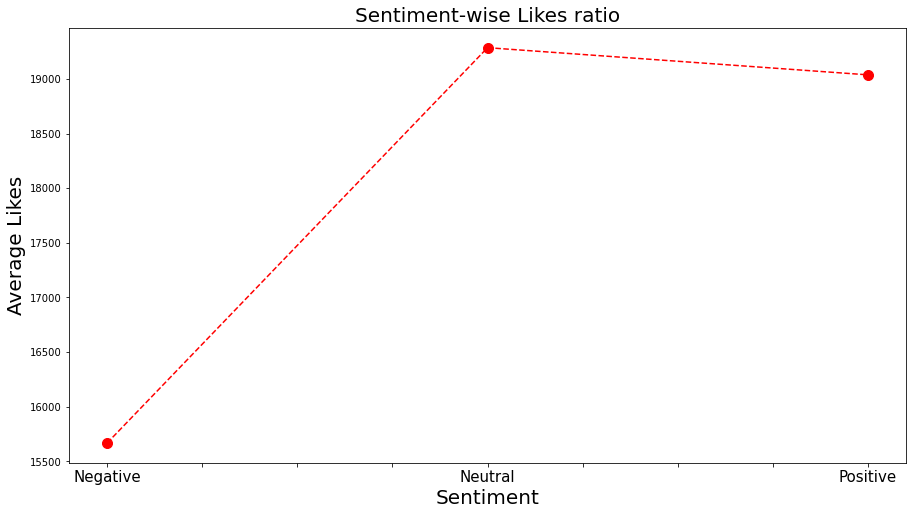

In [ ]:
plt.figure(figsize = (15,8))
df_eng.groupby(['sentiment'])['favourites_count'].mean().plot(color='red', linestyle='dashed', marker='o',
                                                            markerfacecolor='red', markersize=10)
plt.title('Sentiment-wise Likes ratio', fontsize = 20)
plt.xlabel('Sentiment', fontsize = 20)
plt.ylabel('Average Likes', fontsize = 20)
plt.xticks(fontsize = 15)
plt.show()

On average Neutral and Positive tweets gets more likes than Negative tweets.

# Sentiment-wise Retweets ratio

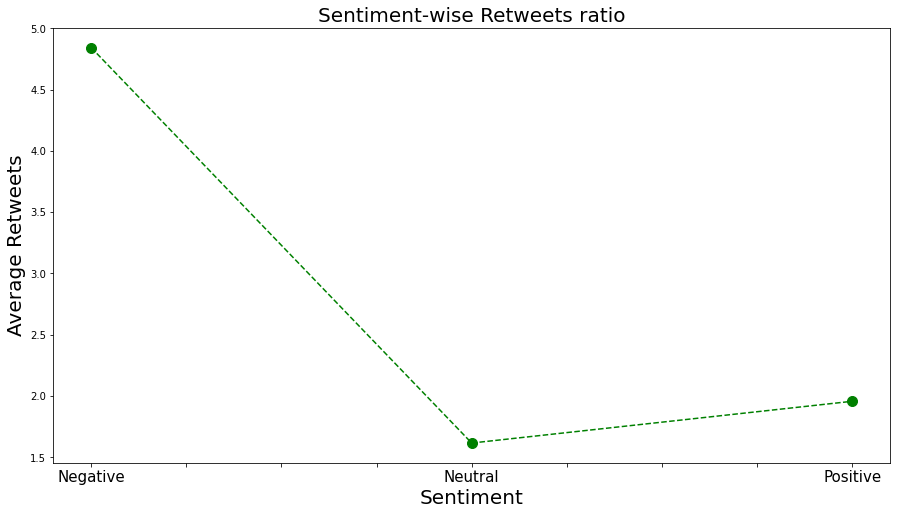

In [ ]:
plt.figure(figsize = (15,8))
df_eng.groupby(['sentiment'])['retweet_count'].mean().plot(color='green', linestyle='dashed', marker='o',
                                                            markerfacecolor='g', markersize=10)
plt.title('Sentiment-wise Retweets ratio', fontsize = 20)
plt.xlabel('Sentiment', fontsize = 20)
plt.ylabel('Average Retweets', fontsize = 20)
plt.xticks(fontsize = 15)
plt.show()

Negative tweets are retweeted the most on average followed by Positive tweets.

## Top 3 Most Liked Tweets

In [ ]:
df_eng.sort_values(by = 'favourites_count', ascending = False).iloc[:3][['text','favourites_count']]

,text,favourites_count
204,this is not a joke!!! details here: https://t.co/xdk56388g5 #donaldtrump #alexrodriguez #arod #coronavirus #covid19,941328
3891,how bout this\r\nsince ca is responsible and did shelter in place early how about you people in florida stay there cuz this makes no sense to scattershot a pandemic.\r\nthat state is horrible \r\n...,739086
7785,how on earth is ca third in cases?!? jesus 😲\r\nhow many test kits did each state recieve?\r\n#covid19 \r\n@sarahbcalif \r\n@drdenagrayson \r\n@dcpoll \r\n\r\ntreat this virus as you would cockroa...,739086


## Top 3 Most Retweeted Tweets

In [ ]:
df_eng.sort_values(by = 'retweet_count', ascending = False).iloc[:3][['text','retweet_count']]

,text,retweet_count
4076,"fidel castro: cuba does not launch bombs against other people. cuba sends doctors around the world, not bombs.\r\n\r\nand just as they led the battle against ebola in 2014, #cuba’s doctors today a...",5443
3320,500 masks in 1 min! an ultra-high-speed mask production line has been launched in beijing to bolster the fight against the novel #coronavirus outbreak https://t.co/5533vxa0jl,996
5239,"if you're able, join us in translating the korean cdc's playbook to fight #covid19 into english! https://t.co/o16h2bg0qi",976


# Time Series Analysis

In [ ]:
df_eng['time'] = pd.to_datetime(df_eng['created_at'])

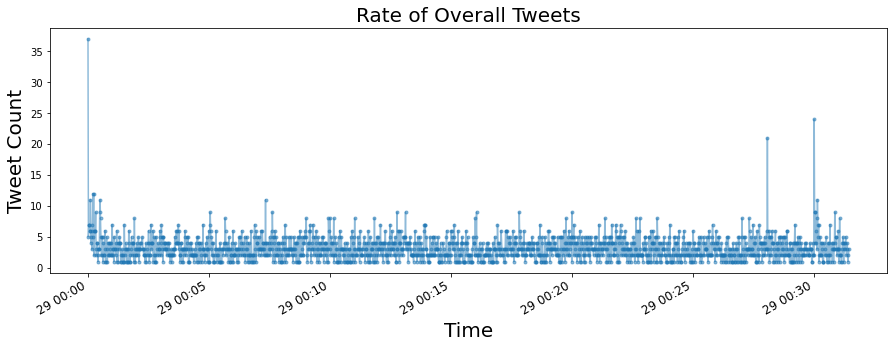

In [ ]:
df_eng.groupby(['time'])['text'].count().plot(marker='.', alpha=0.5, figsize=(15, 5))
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Tweet Count', fontsize = 20)
plt.xticks(fontsize = 12)
plt.title('Rate of Overall Tweets', fontsize = 20)
plt.show()

Overall tweet rate between 00:00 to 00:30

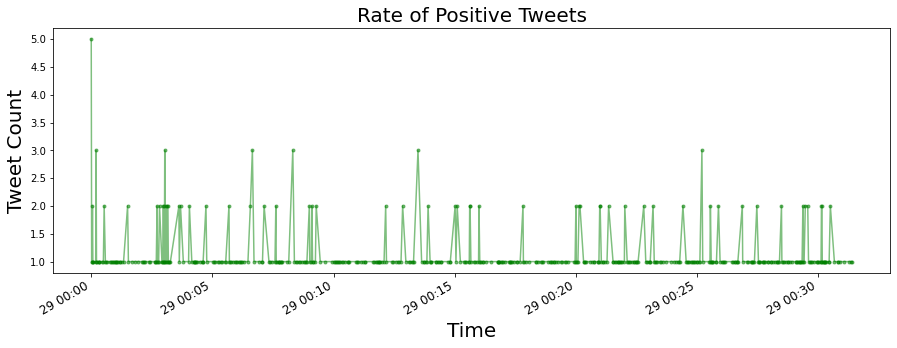

In [ ]:
df_eng[df_eng['sentiment'] == 'Positive'].groupby(['time'])['text'].count().plot(marker='.', alpha=0.5, figsize=(15, 5),
                                                                                 color = 'g',markerfacecolor='g')
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Tweet Count', fontsize = 20)
plt.xticks(fontsize = 12)
plt.title('Rate of Positive Tweets', fontsize = 20)
plt.show()

Positive tweets seem to occur more frequently between 00:00 to 00:25

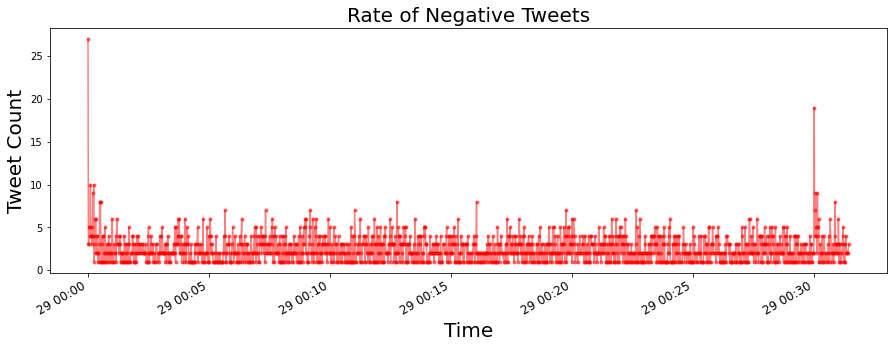

In [ ]:
df_eng[df_eng['sentiment'] == 'Negative'].groupby(['time'])['text'].count().plot(marker='.', alpha=0.5, figsize=(15, 5),
                                                                                 color = 'r',markerfacecolor='r')
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Tweet Count', fontsize = 20)
plt.xticks(fontsize = 12)
plt.title('Rate of Negative Tweets', fontsize = 20)
plt.show()

Negative tweets are more frequent at 00:00 and 00:30.

<b>Topic Modelling</b> helps us to understand and summarise large collections of text. So far we have used <b>WordClouds</b> to manually look through the words and get a basic understanding of the different topics the tweets were related to. But there are much better statistical methods like <b>LDA</b> which can be used to discover <b>abstract topics</b> in a collection of documents.

<b>LDA</b> or <b>Latent Dirichlet Allocation</b> is used to classify text in a document to a particular topic. It backtracks and tries to figure out which topics would create the given documents. Then it assigns words to a given topic with some probability.

In [ ]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(docs)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [ ]:
# Running and Trainign LDA model on the document term matrix.
ldamodel2 = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=10, iterations=10) 

In [ ]:
for idx, topic in ldamodel2.show_topics(formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(idx+1, '|'.join([w[0] for w in topic])))

Topic: 1 
Words: amp|time|social|worker|health|u|due|work|community|state|service|via|care|s|help|need|share|pm|test|patient|staff|video|also|county|provide|distancing|hospital|please|first|grant
Topic: 2 
Words: get|people|u|take|go|need|life|work|amp|make|stay|world|one|know|please|right|like|you|help|home|thank|time|virus|safe|day|let|many|mask|im|thing
Topic: 3 
Words: go|people|get|home|see|stay|love|time|like|one|say|even|im|today|make|thing|think|need|store|still|dont|help|well|pandemic|friend|know|use|way|fuck|take
Topic: 4 
Words: case|death|new|day|report|u|number|covid19|total|rate|confirm|update|get|first|coronavirus|today|health|test|week|two|recover|china|think|double|say|toll|people|year|saturday|march
Topic: 5 
Words: amp|test|trump|people|state|get|need|die|new|like|pandemic|support|spread|positive|know|fight|would|big|crisis|quarantine|time|act|medical|say|he|u|virus|help|stop|coronavirus


The LDA model has managed to classify the words into 5 abstract topics. On reading the individual words of a topic we can see that the words are not randomly assigned and that these words together have some meaning. 